In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from math import sqrt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [4]:
file_path = '/content/drive/MyDrive/DSA2025Spring/rotten_tomatoes_movies.csv'
df = pd.read_csv(file_path)
df.head()

file = '/content/drive/MyDrive/DSA2025Spring/SeasonalTrendResults/monthlyInterest.csv'
df_genre_pop = pd.read_csv(file)
df_genre_pop.head()

columnsKept = ['title', 'audienceScore', 'tomatoMeter', 'genre', 'boxOffice']
df = df[columnsKept]
df = df.drop_duplicates(subset='title')
df['tomatoMeter'] = df['tomatoMeter'].fillna(df['tomatoMeter'].mean())
df['audienceScore'] = df['audienceScore'].fillna(df['audienceScore'].mean())
df = df.dropna(subset=['boxOffice'])

def boxOfficeConvert(boxOffice):
  if pd.isna(boxOffice):
    return np.nan
  boxOffice = boxOffice.replace('$', '')
  if 'M' in boxOffice:
    return float(boxOffice.replace('M', ''))*1000000
  elif 'K' in boxOffice:
      return float(boxOffice.replace('K', ''))*1000
  else:
      return float(boxOffice)

df['boxOffice'] = df['boxOffice'].apply(boxOfficeConvert)

quantile1 = df['boxOffice'].quantile(0.25)
quantile3 = df['boxOffice'].quantile(0.75)
iqr = quantile3 - quantile1

lowerBound = quantile1 - (1.5 * iqr)
upperBound = quantile3 + (1.5 * iqr)

df = df[(df['boxOffice'] >= lowerBound) & (df['boxOffice'] <= upperBound)]
df["main_genre"] = df["genre"].str.split(",").str[0].str.strip()

#one-hot encoding to ensure genre data is readable for the ML phase
df_genre_dummies = pd.get_dummies(df["main_genre"], prefix="genre", drop_first=True)
df = pd.concat([df, df_genre_dummies], axis=1)

peak_rows = df_genre_pop.groupby("genre")["value"].idxmax()
df_peak = df_genre_pop.loc[peak_rows][["genre", "month", "value"]]
df_peak.columns = ["genre", "peak_month", "peak_popularity"]

df["main_genre"] = df["main_genre"].str.lower().str.strip()
df_peak["genre"] = df_peak["genre"].str.lower().str.strip()

df_merged = pd.merge(
  df,
  df_peak,
  left_on="main_genre",
  right_on="genre",
  how="left"
)
df_final = df_merged.dropna(subset=["tomatoMeter", "audienceScore", "peak_popularity", "boxOffice"])

#transforming box office data from numbers to 0 1 binary values according to whether the value is higher or lower than median of all box office data
# (high box office (1) vs low box office (0))
boxOfficeMedian = df_final["boxOffice"].median()
df_final['boxHighLow'] = (df_final['boxOffice'] > boxOfficeMedian).astype(int)

#create a new feature: gap between audience and critic scores to see whether disagreement between audiences and critics have a meaning
df_final['gapOfScores'] = df_final['audienceScore'] - df_final['tomatoMeter']

df_final = df_final.drop(columns=df_final.select_dtypes(include='object').columns)
genreColumns = []
for column in df_final.columns:
  if (column.startswith('genre_')):
    genreColumns.append(column)

#X feature axis of predictor features
X = df_final[['tomatoMeter', 'audienceScore', 'peak_popularity', 'gapOfScores'] + genreColumns]

#Y axis will be box office revenue prediction based on these features
#box office column for regression
yRegression = df_final['boxOffice']

#binary low/high box office column for classification
yClassification = df_final['boxHighLow']

#regression:
xTrainReg, xTestReg, yTrainReg, yTestReg = train_test_split(X, yRegression, test_size = 0.2, random_state = 50) #20/80 test train ratio
randomfReg = RandomForestRegressor(random_state = 50)
randomfReg.fit(xTrainReg, yTrainReg)
regPredict = randomfReg.predict(xTestReg)

rmse = sqrt(mean_squared_error(yTestReg, regPredict))
print("Regression root mean squared error: ", str(rmse))
print("")

#classification:
xTrainClass, xTestClass, yTrainClass, yTestClass = train_test_split(X, yClassification, test_size = 0.2, random_state = 50) #20/80 test train ratio
randomfClass = RandomForestClassifier(random_state = 50, class_weight='balanced') #class weights
randomfClass.fit(xTrainClass, yTrainClass)
classPredict = randomfClass.predict(xTestClass)

accuracy = accuracy_score(yTestClass, classPredict)
print("Classification accuracy: ", accuracy)
print(classification_report(yTestClass,classPredict))

rf_scores = cross_val_score(randomfClass, X, yClassification, cv=5)
print("Random forest cross-validation:", rf_scores.mean())

#logistic regression
logReg = LogisticRegression(max_iter=1000)
logReg.fit(xTrainClass, yTrainClass)
logPredict = logReg.predict(xTestClass)

print("Logistic Regression Accuracy:", accuracy_score(yTestClass, logPredict))
print(classification_report(yTestClass, logPredict))

log_scores = cross_val_score(logReg, X, yClassification, cv=5)
print("Logistic regression cross-validation:", log_scores.mean())

<ipython-input-4-3f24dc0d7352>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['boxHighLow'] = (df_final['boxOffice'] > boxOfficeMedian).astype(int)
<ipython-input-4-3f24dc0d7352>:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['gapOfScores'] = df_final['audienceScore'] - df_final['tomatoMeter']


Regression root mean squared error:  6909439.592084997

Classification accuracy:  0.6221174004192872
              precision    recall  f1-score   support

           0       0.62      0.62      0.62       951
           1       0.62      0.62      0.62       957

    accuracy                           0.62      1908
   macro avg       0.62      0.62      0.62      1908
weighted avg       0.62      0.62      0.62      1908

Random forest cross-validation: 0.6133123689727462
Logistic Regression Accuracy: 0.6284067085953878
              precision    recall  f1-score   support

           0       0.63      0.63      0.63       951
           1       0.63      0.63      0.63       957

    accuracy                           0.63      1908
   macro avg       0.63      0.63      0.63      1908
weighted avg       0.63      0.63      0.63      1908

Logistic regression cross-validation: 0.6227463312368974


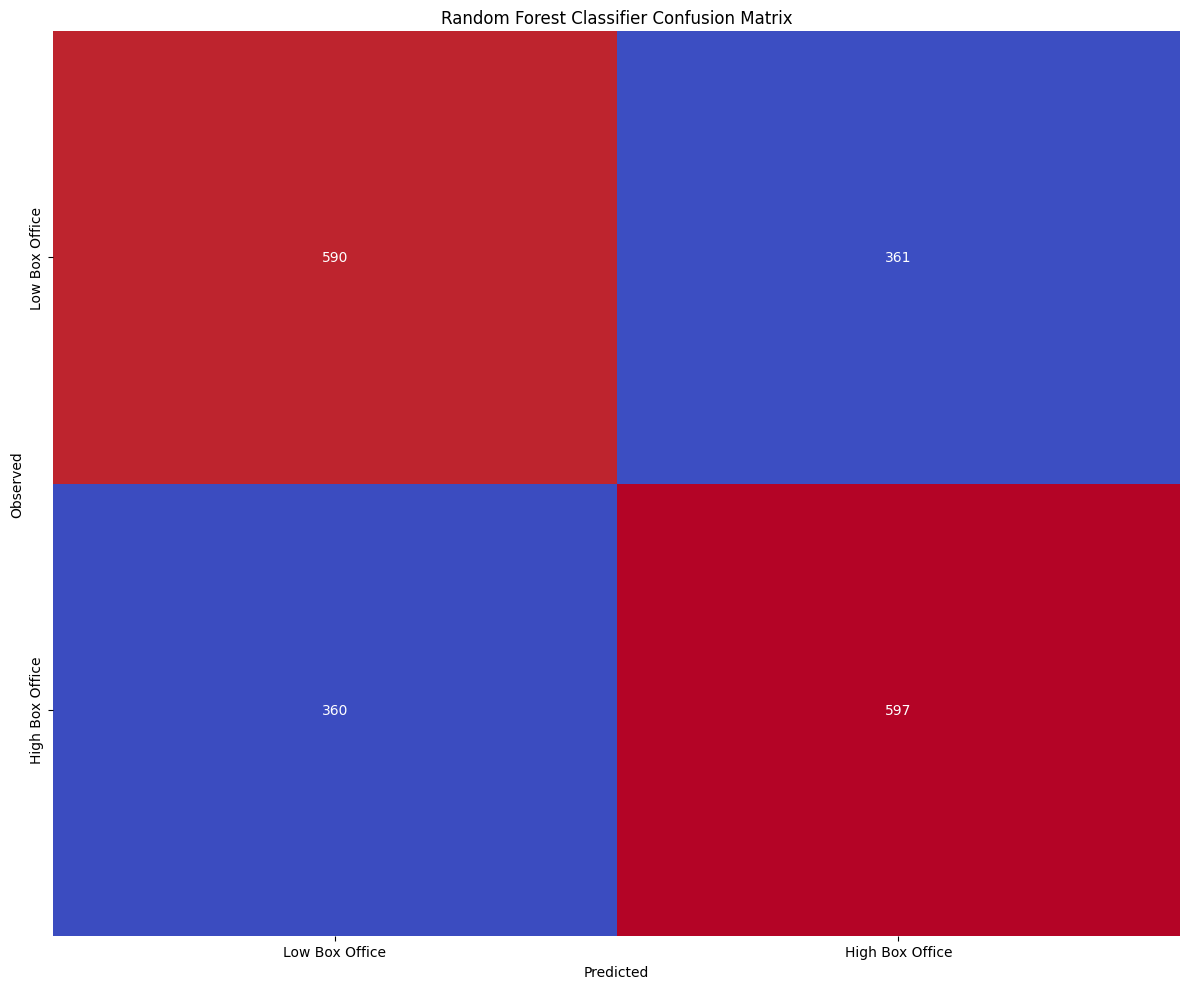

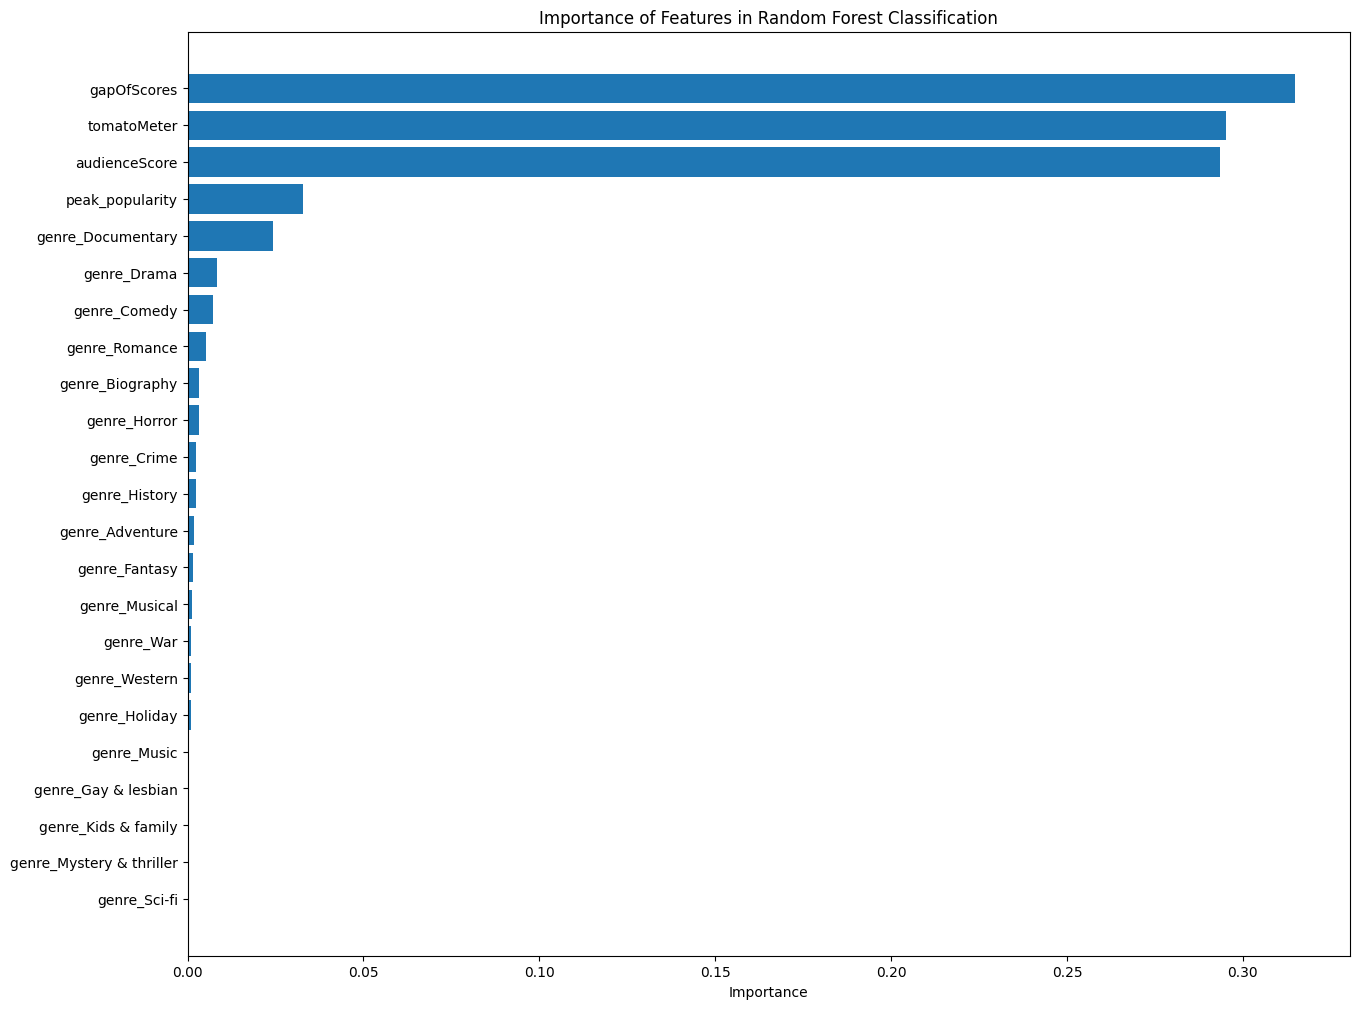

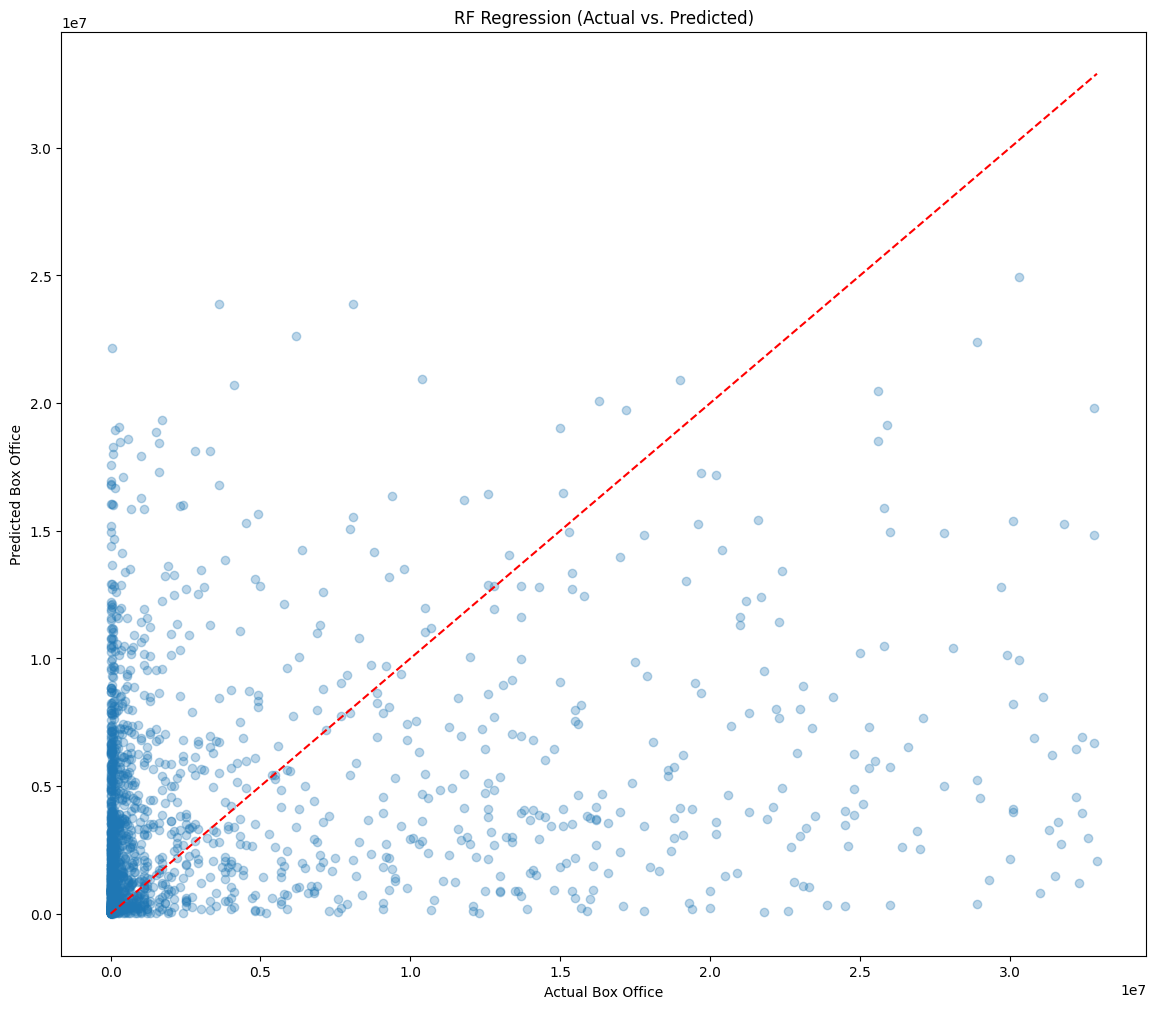

In [5]:
conf_matrix = confusion_matrix(yTestClass, classPredict)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', cbar=False, xticklabels=["Low Box Office", "High Box Office"], yticklabels=["Low Box Office", "High Box Office"])
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.title("Random Forest Classifier Confusion Matrix")
plt.tight_layout()
plt.show()

importances = randomfClass.feature_importances_
features = X.columns
feat_imp_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(15,12))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'])
plt.gca().invert_yaxis()
plt.title('Importance of Features in Random Forest Classification')
plt.xlabel('Importance')
plt.show()

plt.figure(figsize=(14,12))
plt.scatter(yTestReg, regPredict, alpha=0.3)
plt.plot([yTestReg.min(), yTestReg.max()], [yTestReg.min(), yTestReg.max()], 'r--')
plt.xlabel('Actual Box Office')
plt.ylabel('Predicted Box Office')
plt.title('RF Regression (Actual vs. Predicted)')
plt.show()